In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import kornia.augmentation as K
import kornia.feature as F
import sys
import numpy as np
import matplotlib.pyplot as plt
import mido
from mido import MidiFile, MidiTrack, Message
import numpy as np

In [2]:
print(os.listdir(os.getcwd()))
# select quake2.mid
f_name = list(filter(lambda x: x == 'quake2.mid', os.listdir(os.getcwd())))
if len(f_name) <= 0:
    raise RuntimeError('no file name specified')
elif isinstance(f_name, list):
        f_name = f_name[0]

print(f_name)

['.ipynb_checkpoints', 'quake2.mid', 'Untitled.ipynb']
quake2.mid


In [3]:
num_notes = 96
samples_per_measure = 96

def midi_to_samples(fname):
	has_time_sig = False
	flag_warning = False
	mid = MidiFile(fname)
	ticks_per_beat = mid.ticks_per_beat
	ticks_per_measure = 4 * ticks_per_beat

	for i, track in enumerate(mid.tracks):
		for msg in track:
			if msg.type == 'time_signature':
				new_tpm = msg.numerator * ticks_per_beat * 4 / msg.denominator
				if has_time_sig and new_tpm != ticks_per_measure:
					flag_warning = True
				ticks_per_measure = new_tpm
				has_time_sig = True
	if flag_warning:
		print("  ^^^^^^ WARNING ^^^^^^")
		print("    " + fname )
		print("    Detected multiple distinct time signatures.")
		print("  ^^^^^^ WARNING ^^^^^^")
		return []
	
	all_notes = {}
	for i, track in enumerate(mid.tracks):
		abs_time = 0
		for msg in track:
			abs_time += msg.time
			if msg.type == 'note_on':
				if msg.velocity == 0:
					continue
				note = msg.note - (128 - num_notes)/2
				assert(note >= 0 and note < num_notes)
				if note not in all_notes:
					all_notes[note] = []
				else:
					single_note = all_notes[note][-1]
					if len(single_note) == 1:
						single_note.append(single_note[0] + 1)
				all_notes[note].append([abs_time * samples_per_measure / ticks_per_measure])
			elif msg.type == 'note_off':
				if len(all_notes[note][-1]) != 1:
					continue
				all_notes[note][-1].append(abs_time * samples_per_measure / ticks_per_measure)
	for note in all_notes:
		for start_end in all_notes[note]:
			if len(start_end) == 1:
				start_end.append(start_end[0] + 1)
	samples = []
	for note in all_notes:
		for start, end in all_notes[note]:
			sample_ix = int(start / samples_per_measure)
			while len(samples) <= sample_ix:
				samples.append(np.zeros((samples_per_measure, num_notes), dtype=np.uint8))
			sample = samples[sample_ix]
			start_ix = start - sample_ix * samples_per_measure
			if False:
				end_ix = min(end - sample_ix * samples_per_measure, samples_per_measure)
				while start_ix < end_ix:
					sample[start_ix, note] = 1
					start_ix += 1
			else:
				sample[start_ix, note] = 1
	return samples

def samples_to_midi(samples, fname, ticks_per_sample, thresh=0.5):
	mid = MidiFile()
	track = MidiTrack()
	mid.tracks.append(track)
	ticks_per_beat = mid.ticks_per_beat
	ticks_per_measure = 4 * ticks_per_beat
	ticks_per_sample = ticks_per_measure / samples_per_measure
	abs_time = 0
	last_time = 0
	for sample in samples:
		for y in xrange(sample.shape[0]):
			abs_time += ticks_per_sample
			for x in xrange(sample.shape[1]):
				note = x + (128 - num_notes)/2
				if sample[y,x] >= thresh and (y == 0 or sample[y-1,x] < thresh):
					delta_time = abs_time - last_time
					track.append(Message('note_on', note=note, velocity=127, time=delta_time))
					last_time = abs_time
				if sample[y,x] >= thresh and (y == sample.shape[0]-1 or sample[y+1,x] < thresh):
					delta_time = abs_time - last_time
					track.append(Message('note_off', note=note, velocity=127, time=delta_time))
					last_time = abs_time
	mid.save(fname)

In [245]:
def midi_to_pianoroll(f_name, **kwargs):
    '''
    f_name: filename as string
    
    - note
    - type
    - velocity
    - track (with label) -> doesn't really matter we want to split these into seperate pianoroll samples
     - TODO: important! update to 3d convolutions across tracks pretty early (after temporal convolution)
    kwargs: dict of attributes that should be stacked into the pianoroll
            these should be midiattr object that can have a multiplicative konstant
    '''
    attrs = kwargs['attrs']
    attr_indices = dict([(key, index) for index, key in enumerate(attrs.keys())]) # dict of attr index pairs allow access to tensor index by passing message.type
    
    decay = kwargs['decay'] #exponential decay factor
    decay = torch.ones(96) * decay
    attack_override = kwargs['attack_override'] # "velocity override (multiplicative)"
    tempo = mido.bpm2tempo(kwargs['sampling_tempo'])
    midi = MidiFile(f_name)
    t_s  = midi.length
    print(f"midi file length: {t_s}")
    
    ticks_per_beat = midi.ticks_per_beat
    numerator = 4
    denominator = 4
    
    T = len(midi.tracks)
    A = len(attrs)
    all_messages = [track for track in midi]
    n = 0
    times_list = []
    all_messages.sort(key=lambda message: message.time)
    abstime = 0.
    for message in all_messages:
        abstime += message.time 
        if message.is_meta:
            #print(f'metamessage: {message}')
            if message.type == 'end_of_track':
                print(f'end_of_track at: {message.time}')
            if message.type == 'set_tempo':
                print(f'tempo: {message.tempo}')
                tempo = message.tempo
            if message.type == 'time_signature':
                numerator = message.numerator
                denominator = message.denominator        
        times_list.append(message.time)
        try: 
            n = max(n, message.time)
        except:
            pass
    
    print(f'"abstime": {abstime}')
    
    ticks_per_measure = numerator * ticks_per_beat
    print(f'time_sig: {numerator}/{denominator}')
    
    # calculate how long a measure is in seconds
    measure_duration_s = mido.tick2second(ticks_per_measure, ticks_per_beat, tempo)
    print(f"measure duration: {measure_duration_s}s")
    
    # calculate number of measures by dividing total length by measure length (both in seconds)
    n = int(np.ceil(t_s / measure_duration_s))
    print(f'total measures in song: {n}')
    
    S_t = torch.zeros(size=(int(T), int(A), 96 * n, 96)) # example: quake2.mid: 96 * 33 * 96 = 3186 * 96
    dim_x = 96 * n
    # t-batch of a-channel 3186 * 96 images
    print(f'S_T.shape: {S_t.shape}')
    abs_time = 0.0 # absolute time elapsed since playback began in seconds
    for t, track in enumerate(midi.tracks):
        max_pos = [0.0, 0.0]
        active_notes = torch.zeros(96) #logs current activation of note at y using a float mask
        # used as mask that sweeps over sample tensor while get messages in the order they are played            
        
        # A = len(midi.message types)
        # n = total ticks / ticks_per_measure 
        # basically turns song into long ass 3d tensor [][][]....[][] of n * (96 x T x 96) cubes
        # note that the sample tensor will be rather sparse with a lot of zeros in their volume
        
        #print(f'track[{t}]: {track}')
        for m, message in enumerate(track):
            # -> track time 
            
            if str(message.type) in attrs:
                '''
                try:
                    pos_y = message.pos
                except:
                    print(f'the midi attribute {message} (time attribute != time position in track, which is pos) was marked as interesting yet has no timing information')
                    print('this currently just puts the attribute at y = 0')
                    pos_y = 0
                '''
                # (virtually) position interesting midi event on Sample tensor 
                if message.is_meta:
                    pos_x = 0
                else:
                    print(f"abs_time: {abs_time} / t_s: {t_s} = {abs_time / t_s}")
                    pos_x = abs_time / t_s # example: quake 2 total playing time = 62.0s -> abstime will add to 62.0s
                    pos_x = int(pos_x)
                    
                pos_y = message.note - (128 - num_notes)/2
                pos_y = int(pos_y)
                max_pos[0] = max(max_pos[0], pos_x)
                max_pos[1] = max(max_pos[1], pos_y)
                #print(f"pos: [{pos_x}, {pos_y}]")
                # -> invisible notes will be logged
                if message.velocity == 0:
                    continue
                # -> visible notes will be logged overwriting pixel values
                note = message.note # - (128 - num_notes)/2
                note = int(note)
                # -> get index in [t] dimension of sample tensor
                attr_idx = attr_indices[message.type]
                
                
                #print(active_notes.shape)
                eps = 0.001

                active_notes[note] = float(message.velocity) / 128.

                active_notes = torch.max(active_notes * decay - eps, torch.zeros(96))
                    
                if message.type == 'note_off':
                    active_notes[note] = 0.
                    
                #print(f"abstime: {abs_time}")
                S_t[t, attr_idx, pos_x, :] = active_notes #active_notes[note]
                
            # outside if    
            abs_time += message.time
            #print(f"S_T.shape: {S_t[t, attr_idx, pos_x, :].shape}") # = active_notes #float(message.velocity) / 128.
        print(max_pos)      
    
    #t, a, x, y = S_t.shape
    #n = x // 96
    #S_t = S_t.view((n, t, a, 96, y))
    #mask = S_t.mean(dim=(1, 2, 3, 4)) > 0.0 # mask stack elements that dont show any activation
    #keep = mask.sum() # number of stacks to keep
    #print(f'kept {keep} of {n} measures')
    #print(f'mask: {mask}')
    #mask = mask.repeat_interleave(t*a*96*y)
    #print(S_t.view(-1).shape)
    #print(mask.shape)
    #print(torch.masked_select(t.view(-1), mask).view(keep, 3, 10, 10).shape)
    
    return S_t#torch.masked_select(S_t.view(-1), mask).view(t, a, 96 * keep, y)

    # uncomment when stable!!
    #return torch.tensor(torch.masked_select(S_t.view(-1), mask).view(keep, t, a, 96, y), names=("Measure", "Track", "Atrribute", "time", "pitch"))

                
        #print(f'track:{track}')

In [246]:
interesting_attrs = {
    'note_on' : 1.0,
    'polytouch': 1.0,
    #'aftertouch': 1.0,
    'note_off': 1.0,
} # basically a dict that stores what attribute contributes how much to the intensities in tensor
print('note_on' in interesting_attrs)

s = midi_to_pianoroll(f_name, attrs=interesting_attrs, decay=0.95, attack_override=None, sampling_tempo=120.)
print(s.shape)

clip = s[:,:,96*0:4*96]
print(clip.shape)
view_pianoroll(clip.sum(dim=(0, 1))) # view 4 measures

True
midi file length: 62.857079999998476
tempo: 476190
end_of_track at: 1.8849187500000002
"abstime": 62.85707999999895
time_sig: 4/4
measure duration: 1.9047600000000002s
total measures in song: 33
S_T.shape: torch.Size([10, 3, 3168, 96])
[0.0, 0.0]
abs_time: 63360.0 / t_s: 62.857079999998476 = 1008.0010080010325
abs_time: 71040.0 / t_s: 62.857079999998476 = 1130.182948364794
abs_time: 71040.0 / t_s: 62.857079999998476 = 1130.182948364794
abs_time: 71100.0 / t_s: 62.857079999998476 = 1131.137494773886
abs_time: 71100.0 / t_s: 62.857079999998476 = 1131.137494773886
abs_time: 71160.0 / t_s: 62.857079999998476 = 1132.0920411829777
abs_time: 71160.0 / t_s: 62.857079999998476 = 1132.0920411829777
abs_time: 71220.0 / t_s: 62.857079999998476 = 1133.0465875920697
abs_time: 71220.0 / t_s: 62.857079999998476 = 1133.0465875920697
abs_time: 71280.0 / t_s: 62.857079999998476 = 1134.0011340011615
abs_time: 71280.0 / t_s: 62.857079999998476 = 1134.0011340011615
abs_time: 71340.0 / t_s: 62.857079999

abs_time: 80760.0 / t_s: 62.857079999998476 = 1284.8194666376796
abs_time: 80820.0 / t_s: 62.857079999998476 = 1285.7740130467714
abs_time: 80820.0 / t_s: 62.857079999998476 = 1285.7740130467714
abs_time: 80880.0 / t_s: 62.857079999998476 = 1286.7285594558634
abs_time: 80880.0 / t_s: 62.857079999998476 = 1286.7285594558634
abs_time: 80940.0 / t_s: 62.857079999998476 = 1287.6831058649552
abs_time: 80940.0 / t_s: 62.857079999998476 = 1287.6831058649552
abs_time: 81000.0 / t_s: 62.857079999998476 = 1288.6376522740472
abs_time: 81000.0 / t_s: 62.857079999998476 = 1288.6376522740472
abs_time: 81060.0 / t_s: 62.857079999998476 = 1289.592198683139
abs_time: 81060.0 / t_s: 62.857079999998476 = 1289.592198683139
abs_time: 81120.0 / t_s: 62.857079999998476 = 1290.5467450922308
abs_time: 81120.0 / t_s: 62.857079999998476 = 1290.5467450922308
abs_time: 81180.0 / t_s: 62.857079999998476 = 1291.5012915013228
abs_time: 81180.0 / t_s: 62.857079999998476 = 1291.5012915013228
abs_time: 81240.0 / t_s: 62

IndexError: index 3168 is out of bounds for dimension 2 with size 3168

In [6]:
def musicsheet(batch_size=4, note_freq=64):
    m = torch.zeros(4, 3, 96, 96)
    for n in range(note_freq):
        randx, randy = np.random.randint(96), np.random.randint(96)
        length = np.random.randint(24)
        a = np.random.uniform(0.5, 1.0)
        s = np.random.uniform(0.0, a)
        d = np.random.uniform(0.0, s)
        randb = np.random.randint(4)
        m[randb, 0, randx:int(randx+length), randy] = a
        m[randb, 1, randx:int(randx+length / 3), randy] = s
        m[randb, 2, randx:int(randx+length / 5), randy] = d
    return m

In [7]:
#plt.imshow(m[0].transpose(0,2))

In [8]:
def log_volume(t, r=None):
    print(f'tensor shape:{t.shape}')
    vol = np.product(t.shape[1:])
    r_vol = vol if not r else r
    print(f'absolute tensor volume:{vol}')
    print(f'volume reduction:{vol / r_vol}')
    #print(f'latent space development:{str(chr(9608)) * int(20. / (vol / r_vol))}')
    return vol

In [9]:
def view_pianoroll(batch, url=None):
    fig = plt.subplot()
    fig.set_title(url)
    img_grid = torchvision.utils.make_grid(batch, nrow=1)
    fig.imshow(img_grid.transpose(0, 2), url=url)
    plt.show()

In [10]:
import math
def tensor_memory(a):
    def convert_size(size_bytes):
       if size_bytes == 0:
           return "0B"
       size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
       i = int(math.floor(math.log(size_bytes, 1024)))
       p = math.pow(1024, i)
       s = round(size_bytes / p, 2)
       return "%s %s" % (s, size_name[i])
    print(f'memory {convert_size(a.element_size() * a.nelement())}')

N Paramters: 312117
memory 10.55 MB
torch.Size([10, 3, 960, 96])


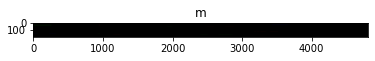

gfft.shape:torch.Size([10, 3, 960, 96])


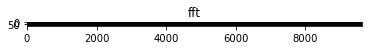

mu: torch.Size([10, 315]); var: torch.Size([10, 315]);
[tensor([[-0.0735, -0.1638, -0.1091,  ...,  0.0178,  0.0304,  0.0668],
        [-0.3064, -0.0699, -0.1426,  ..., -0.1705, -0.1773,  0.2035],
        [-0.0521,  0.0366,  0.0032,  ..., -0.0677, -0.0456, -0.0136],
        ...,
        [-0.0980, -0.2964, -0.1831,  ...,  0.0142, -0.3735,  0.5745],
        [-0.0489,  0.0386, -0.0076,  ..., -0.0374, -0.0166, -0.0182],
        [-0.3481,  0.0528, -0.0353,  ...,  0.0392,  0.0240, -0.1475]],
       grad_fn=<AddmmBackward>), tensor([[ 0.1063, -0.1695,  0.0196,  ..., -0.1668,  0.0646,  0.0681],
        [ 0.0129,  0.0813,  0.1665,  ..., -0.1884,  0.0081,  0.1871],
        [ 0.0213, -0.0244,  0.0558,  ..., -0.0356, -0.0088,  0.0094],
        ...,
        [ 0.1242, -0.1847, -0.2232,  ..., -0.3807,  0.3610,  0.3581],
        [ 0.0184,  0.0070,  0.0541,  ..., -0.0410, -0.0077,  0.0189],
        [ 0.1268, -0.1769, -0.2099,  ..., -0.3574, -0.1448, -0.2207]],
       grad_fn=<AddmmBackward>)]


IndexError: list index out of range

In [66]:

class ComposerVAE(nn.Module):
    
    class MeasureCell(nn.Module):
        ''' Auto Encoder that encodes a batch of measures for a single track into my and sig latent vectors'''
        def __init__(self):
            super(ComposerVAE.MeasureCell, self).__init__()
            conv_1xnx1 = lambda n, s: torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(n, 1), stride=(s, 1))
            self.conv_1x3x1 = conv_1xnx1(3, 2) #needs to be stacked twice
            self.bn_1 = torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.leaky_relu = torch.nn.functional.leaky_relu_
            self.conv_1x6x1 = conv_1xnx1(6, 3) #needs to be stacked twice
            self.conv_1x12x1 = conv_1xnx1(12, 3) #needs to be stacked twice
            # first spatial convolution combines a,s,d to single channel
            self.conv_3x5x5 = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), stride=(1, 1))
            # convolution for first branch looking for melody correlations
            self.conv_1x3x3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1, 2))
            self.bn_2 = torch.nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv_1x5x5 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 5), stride=(1, 2))
            
            
            self.encoder = nn.Sequential(
                torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 1), stride=(2, 1)),
                torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 1), stride=(2, 1)),
                torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(6, 1), stride=(3, 1)),
                torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(12, 1), stride=(3, 1)),
                torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.LeakyReLU(),
                # end of only temporal convolution
                torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3, 3), stride=(1, 1)),
                torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1, 2)),
                torch.nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 5), stride=(1, 2)),
                torch.nn.LeakyReLU()
            )
            
            self.fc_mu = nn.Linear(315, 315)
            self.fc_var = nn.Linear(315, 315)
            self.encode_shape = None #torch.Size(315)
            self.decoder_input = nn.Linear(315, 315)
            
            self.decoder = nn.Sequential(
        
                torch.nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(5, 5), stride=(1, 2)),
                torch.nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=(1, 2)),
                torch.nn.ConvTranspose2d(in_channels=1, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
                torch.nn.LeakyReLU(),
                
                torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(12, 1), stride=(3, 1)),
                torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(6, 1), stride=(3, 1)),
                torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                
                torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3, 1), stride=(2, 1)),
                torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3, 1), stride=(2, 1)),
                torch.nn.LeakyReLU()
            )
            
            self.final_layer = nn.Sequential(
                nn.Tanh()
            )
            
            
            # before (measures, tracks, attributes, x, y)
            # batch shape: (songs, measures, tracks, attributes, x, y)
            #self.conv_1x3x1 = torch.nn.Conv3d(in_channels=3, out_channels=3, kernel_size=(3, 1, 1), stride=2)
            # "Chord filters"
            
        def reparameterize(self, mu: torch.tensor, logvar: torch.tensor) -> torch.tensor:
            """
            Reparameterization trick to sample from N(mu, var) from
            N(0,1).
            :param mu: (Tensor) Mean of the latent Gaussian [B x D]
            :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
            :return: (Tensor) [B x D]
            """
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu
        
        def forward(self, input: torch.tensor, **kwargs):
            mu, log_var = self.encode(input)
            z = self.reparameterize(mu, log_var)
            return  [self.decode(z), input, z, mu, log_var]
        
        def decode(self, z):
            result = self.decoder_input(z)
            result = result.view(self.encode_shape)
            result = self.decoder(result)
            result = self.final_layer(result)
            return result
            
        def encode(self, m):
            result = self.encoder(m)
            self.encode_shape = result.shape
            result = torch.flatten(result, start_dim=1)
            mu = self.fc_mu(result)
            log_var = self.fc_var(result)
            print(f'mu: {mu.shape}; var: {log_var.shape};')
            # 315 x 1 vectors of latent space
            return [mu, log_var]
        
        def old_encode(self, m):
            
            assert m.ndim == 4 # make sure m is a batch of a * x * y measures
            
            #first some convolutions along the temporal(x)-Axis
            last = log_volume(m)
                                     #  _ _ _      _        _ _ _      _
            m = self.conv_1x3x1(m)   # |_|_|_| -> |_| = >  |_|_|_| -> |_| 

            last= log_volume(m, last)
            
            m = self.bn_1(m)         #  _ _ _      _        _ _ _ _ _ _      _
            m = self.conv_1x3x1(m)   # |_|_|_| -> |_| = >  |_|_|_|_|_|_| -> |_|

            last= log_volume(m, last)

            m = self.bn_1(m)               #  _ _ _ _ _ _      _ 
            m = self.conv_1x6x1(m)         # |_|_|_|_|_|_| -> |_|

            last = log_volume(m, last)     
                                           #  _ _ _ _ _ _ _ _ _ _ _ _ 
            m = self.conv_1x12x1(m)        # |1|2|3|4|5|6|7|8|9|1|1|1|

            last = log_volume(m, last)

            img_grid = torchvision.utils.make_grid(m, nrow=1)
            print(f'max: {torch.max(img_grid)}')
            plt.imshow(img_grid.transpose(0, 2).detach())
            plt.show()
            
            ######### BRANCH 1 #############

            # next look for some correlations in the 2d plane
            # make sure to have extra convolutions using 'chord filters'
            #                                               _ _ _ _ _
            #                                                       /|  _
            #                                                     /|/|  /|
            #                                         _ _ _ _ _ /|/|/|       Isolate Notes normalized temporal space
            #                                        |_|_|_|_|_|/|/|/|
            #                                        |_|_|_|_|_|/|/|/|
            #                                      # |_|_|_|_|_|/|/|/
            m_branch1 = self.bn_1(m)               # |_|_|_|_|_|/|/
            m_branch1 = self.conv_3x5x5(m_branch1) # |_|_|_|_|_|/

            last = log_volume(m_branch1, last)

            m_branch1 = self.bn_2(m_branch1)
            m_branch1 = self.conv_1x3x3(m_branch1) # first convolution over spots in note space 

            last = log_volume(m_branch1, last)

            m_branch1 = self.conv_1x5x5(m_branch1) # second convolution over spots in note space 

            last = log_volume(m_branch1, last)

            m_branch1 = self.conv_1x5x5(m_branch1)

            last = log_volume(m_branch1, last)
            
            m_branch1 = self.leaky_relu(m_branch1)
            
            plt.imshow(m_branch1[0].detach().squeeze(0))
            plt.show()
            
            ########## branch_2 ##########
            
            m_branch2 = self.bn_1(m)
            
            
            return m_branch1
            
            
    class MergerCell(nn.Module):
        ''' AutoencoderCell that merges sampled latent vectors of MeasureCell's into my and sig latent vectors'''
        def __init__(self, inchannels=10):
            super(ComposerVAE.MergerCell, self).__init__()
            self.conv_3x3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
            self.encoder = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(2),
                nn.LeakyReLU()
            )
            self.fc_mu = nn.Linear(64, 64)
            self.fc_var = nn.Linear(64, 64)
            self.decoder_input = nn.Linear(64, 64)
            self.encode_shape = None
            
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(in_channels=2, out_channels=3, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(3),
                nn.LeakyReLU()
            )
            self.final_layer = nn.Tanh()
            
        def forward(self, t):
            #assert t.ndim == 4 # make sure that t is a batch of s * t * m * a * x * y
            t = t.view(-1, 3, 7, 15) # reshape sample vector to 2d image batch
            mu, log_var = self.encode(t)
            z = self.reparameterize(mu, log_var)
            return [self.decode(z), input, z, mu, log_var]
            '''
            print(t.shape)
            
            return self.encode(t)
            '''
        
        def reparameterize(self, mu: torch.tensor, logvar: torch.tensor) -> torch.tensor:
            """
            Reparameterization trick to sample from N(mu, var) from
            N(0,1).
            :param mu: (Tensor) Mean of the latent Gaussian [B x D]
            :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
            :return: (Tensor) [B x D]
            """
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu
        
        def decode(self, z):
            result = self.decoder_input(z)
            result = result.view(self.encode_shape)
            result = self.decoder(result)
            result = self.final_layer(result)
            return result
            
        
        def encode(self, t):
            batch, c, w, h = t.shape
            result = self.encoder(t)
            self.encode_shape = result.shape
            result = result.view(batch, -1)
            mu = self.fc_mu(result)
            log_var = self.fc_var(result)
            return [mu, log_var]
            
    def __init__(self, max_tracks=10):
        super(ComposerVAE, self).__init__()
        self.merger_cell = self.MergerCell()
        self.measure_cell = self.MeasureCell()
        
    
    def forward(self, s):
        # takes a minibatch of m * a * x * y
        # measures: m
        # tracks: t
        # attributes: a
        # length: x
        # width: y
        
        # -> measures for different tracks can be flattened because we treat tracks of songs like songs
        
        # pass each track through measure cell
        #s = s.transpose(1, 2) #switch measure and track dimension
        mc_s = self.measure_cell.encode(s) # sample of measure cell (batch of tracks)
        print(mc_s)
        #containing: [reconstruction, input, sampled_vector z, mu, log_var]
        f_s = self.merger_cell(mc_s[2])[0] # merge samples for different tracks into one latent vector describing the song
        print(f_s.shape)
            
    
model = ComposerVAE()

def modelstats(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'N Paramters: {params}')

modelstats(model)
track, attr, x, y = s.shape
m = s #musicsheet()
b_m = m
tensor_memory(b_m)
#b_m = musicsheet()
print(b_m.shape)
gfft = F.gftt_response(b_m)

img_grid = torchvision.utils.make_grid(b_m[0:10], nrow=2)
view_pianoroll(img_grid, url='m')
'''plt.figure.set_title('m')
plt.imshow(img_grid.transpose(0, 2))
plt.show()'''

print(f'gfft.shape:{gfft.shape}')
fft_grid = torchvision.utils.make_grid(gfft[0:10], nrow=1)
view_pianoroll(fft_grid, url='fft')
'''plt.figure(title='fft')
plt.imshow(fft_grid.transpose(0, 2))
plt.show()'''

#plt.imshow(m[0].transpose(0, 2))
model(b_m)

In [ ]:
np.random.uniform(0.5, 1.0)

In [ ]:
np.product((45, 72, 92))

In [ ]:
attrs = {'h': 1.0, 'k': 0.5}
s = dict([(key, index) for index, key in enumerate(attrs.keys())])

In [ ]:
s['h']

In [ ]:
t = torch.randn(4, 3, 10, 10)
mask = t.mean(dim=(1, 2, 3)) > 0.0
keep = mask.sum()
print(keep)
print(mask)
mask = mask.repeat_interleave(3*10*10)
print(mask.shape)
plt.plot(mask)
plt.show()
print(torch.masked_select(t.view(-1), mask).view(keep, 3, 10, 10).shape)

In [ ]:
assert isinstance(8, str)
print('daggi')

In [26]:
test = torch.randn([100, 3, 96, 96])
conv_1xnx1 = lambda n: torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(n, 1), stride=1)
conv_1xnx1T = lambda n: torch.nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(n, 1), stride=1)
conv_1x3x1 = conv_1xnx1(3)
conv_1x3x1T = conv_1xnx1T(3)
test = conv_1x3x1(test)
print(test.shape)
test = conv_1x3x1T(test)
print(test.shape)


torch.Size([100, 3, 94, 96])
torch.Size([100, 3, 96, 96])


In [17]:
l1 = torch.nn.Linear(10, 10)

In [30]:
l1(torch.randn(10))
print(type(test.size()))

<class 'torch.Size'>


tensor([0.0000, 0.0000, 0.2379, 0.0000, 0.0000, 0.0000, 0.6558, 0.0000, 0.0000,
        0.5369, 0.0000, 0.0000, 0.0000, 0.5349, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6043, 0.5082, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5282, 0.0000, 0.0000, 0.0000, 0.0000, 0.2541, 0.0000, 0.0000, 1.5082,
        0.8363, 0.0000, 0.0000, 1.6734, 0.0000, 0.0000, 0.2701, 0.0000, 0.4813,
        0.2590, 0.4554, 0.0718, 0.0000, 0.0162, 0.0000, 0.0000, 0.3778, 0.0860,
        0.0000, 1.0336, 0.0000, 0.0000, 0.0000, 0.4677, 0.6528, 1.1360, 0.0000,
        0.0000, 0.4866, 0.0000, 0.8709, 0.0000, 0.0000, 0.0000, 1.5487, 0.0000,
        0.0000, 0.0000, 0.8145, 0.0000, 0.0000, 0.0000, 1.1598, 0.0000, 0.0000,
        0.0000, 0.1852, 0.6103, 0.0000, 0.9412, 0.0000, 1.0171, 0.0000, 1.1428,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


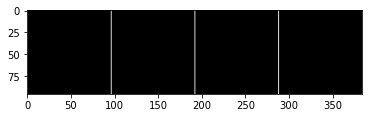

In [5]:
t = torch.zeros(3, 96*4, 96)
t1 = torch.ones(96)
print(torch.max(torch.randn(96) - 0.5, torch.zeros(96)))
for i in range(t.shape[1]):
    if i % 96 == 0:
        t[:,i,:] = t1
plt.imshow(t.transpose(0, 2))

In [7]:
l = [[1, 2], [3, 4], [5, 6]]
for i, e in enumerate(l):
    print(f"l[{i}] = {e}")

l[0] = [1, 2]
l[1] = [3, 4]
l[2] = [5, 6]


In [15]:
if False: print("He")

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Transpose()
])